# Trabalho Prático: Competição Kaggle

## Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, ConfusionMatrixDisplay, classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler

from imblearn.ensemble import BalancedRandomForestClassifier

## Read DataSet

In [2]:
df = pd.read_csv("sbstpdaa2223/training_data.csv")

## Data Visualization

In [3]:
print("** INFO **")
df.info()
#print("** DESCRIBE **")
#print(df.describe())
#print("** CORR MATRIX **")
#plt.figure(figsize = (16,10))
#sns.heatmap(df.corr(), annot=True)
#plt.show()
print("** NULL VALUES?? **") # check if there are any missing values in this dataframe
print(df.isnull().sum())
print("** DUPLICATED VALUES?? **") # check if there are any missing values in this dataframe
print(df.duplicated().sum())

** INFO **
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB
** NULL VALUES?? **
city_name              0
magnitude_of_delay     0
delay_in_seco

In [4]:
print("** HEAD **")
df.head()

** HEAD **


,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High


### Análise da Data Visualization:

* Primeira coisa que podemos observar é que neste data set existem dados categoricos (city_name, magnitude_of_delay, affected_roads, record_date, luminosity,avg_rain), contudo, as funções disponibilizadas pelo sklearn só trabalham com dados numéricos, portanto, é necessário, fazer encoding destes valores.

* Este dataset tem 13 atributos, e 5000 instâncias. Com este dataset pretendemos construir um modelo que permita determinar a gravidade de um acidente, dependendo das condições ambientais desse dia.

* Relembrar que a target label é a coluna **incidents**. Os dados desta classe são do tipo *"ordinal"*.

* Podemos também observar a existência de missing values na coluna **affected_roads**. Para tratar estes podemos tentar diferentes abordagens. Podemos tentar fazer drop dessas linhas (dado que são relativamente poucas linhas 85 em 5000, contudo, devemos verificar se não muita perda de dados), ou replace by the mean (contudo, esta linha é do tipo categórico, temos que ver isso primeiro maybe).

* Os dados apresentados para cada classe "parecem" fazer sentido.

None         2028
High         1073
Low           718
Very_High     603
Medium        578
Name: incidents, dtype: int64

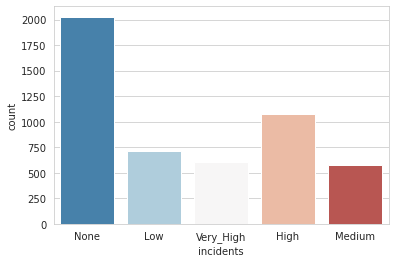

In [5]:
sns.set_style("whitegrid")
sns.countplot(x="incidents", data=df, palette="RdBu_r")

df.incidents.value_counts()

Após uma análise do gráfico, podemos ver que o valor *None* tem cerca de 2018 instâncias, *Low* tem cerca de 663, *Very_High* tem cerca de 603, *High* tem cerca de 1066, *Medium* tem cerca de 565.



## Preprocessing

### Encoding Categorical Data

* Utilizando label encoding

In [6]:
def getReplaceMap(df, nameColumn):
    labels = df[nameColumn].astype('category').cat.categories.tolist()
    replace_map = {nameColumn:{k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    return replace_map

In [7]:
def getReplaceInvertedMap(df):
    labels = df['incidents'].astype('category').cat.categories.tolist()
    replace_map = {'Incidents':{v: k for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    #print(replace_map)
    return replace_map

In [8]:
def replaceRecordDate(df):
    df['record_date'] = pd.to_datetime(df['record_date'], format = "%Y-%m-%d %H:%M", errors='coerce')

    assert df['record_date'].isnull().sum() == 0, 'missing record date'
    
    df['record_date_year'] = df['record_date'].dt.year  #Não tem muito valor => todos estes acidentes foram no mesmo ano
    
    df['record_date_month'] = df['record_date'].dt.month
    df['record_date_day'] = df['record_date'].dt.day
    df['record_date_hour'] = df['record_date'].dt.hour
    
    df.drop('record_date', axis = 1, inplace= True)

In [9]:
def encoding_categorical_data(df):
    replace_map_city_name = getReplaceMap(df,'city_name')
    df.replace(replace_map_city_name, inplace = True)
    
    replace_magnitude_delay = getReplaceMap(df,'magnitude_of_delay')
    print(replace_magnitude_delay)
    df.replace(replace_magnitude_delay, inplace=True)
    
    #replace_affected_roads = getReplaceMap(df, 'affected_roads')
    #df.replace(replace_affected_roads, inplace = True)
    
    replace_luminosity = getReplaceMap(df, 'luminosity')
    print(replace_luminosity)
    df.replace(replace_luminosity, inplace=True)
    
    replace_avg_rain = getReplaceMap(df, 'avg_rain')
    print(replace_avg_rain)
    df.replace(replace_avg_rain, inplace=True)
    
    replaceRecordDate(df)
    
# Get a map to undo encoding to generate document if necessary    
replace_incidents_inverted = getReplaceInvertedMap(df)

encoding_categorical_data(df)

# Encoding incidents need to be handle separately
replace_incidents = getReplaceMap(df, 'incidents')
print(replace_incidents)
df.replace(replace_incidents, inplace=True)

{'magnitude_of_delay': {'MAJOR': 1, 'MODERATE': 2, 'UNDEFINED': 3}}
{'luminosity': {'DARK': 1, 'LIGHT': 2, 'LOW_LIGHT': 3}}
{'avg_rain': {'Sem Chuva': 1, 'chuva forte': 2, 'chuva fraca': 3, 'chuva moderada': 4}}
{'incidents': {'High': 1, 'Low': 2, 'Medium': 3, 'None': 4, 'Very_High': 5}}


### Data Visualization After Encoding Categorical Data

In [10]:
print("** HEAD **")
df.head()

** HEAD **


,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents,record_date_year,record_date_month,record_date_day,record_date_hour
0,1,3,0,",",1,12.0,1013.0,70.0,1.0,0.0,1,4,2021,3,15,23
1,1,3,385,"N101,",1,12.0,1007.0,91.0,1.0,0.0,1,4,2021,12,25,18
2,1,3,69,",",2,14.0,1025.0,64.0,0.0,0.0,1,2,2021,3,12,15
3,1,1,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2,15.0,1028.0,75.0,1.0,0.0,1,5,2021,9,29,9
4,1,3,0,"N101,N101,N101,N101,N101,",2,27.0,1020.0,52.0,1.0,0.0,1,1,2021,6,13,11


In [11]:
print("** DESCRIBE **")
df.describe()

** DESCRIBE **


,city_name,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents,record_date_year,record_date_month,record_date_day,record_date_hour
count,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.00000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000
mean,1.0,2.727200,560.567000,1.539400,14.583000,1018.145000,74.455000,1.253500,0.0,1.10240,3.074000,2021.0,7.131600,15.888400,11.404800
std,0.0,0.685328,1686.859581,0.568254,4.820514,5.174372,17.204638,1.269847,0.0,0.45821,1.372917,0.0,3.442129,8.734736,6.910404
min,1.0,1.000000,0.000000,1.000000,1.000000,997.000000,6.000000,0.000000,0.0,1.00000,1.000000,2021.0,1.000000,1.000000,0.000000
25%,1.0,3.000000,0.000000,1.000000,11.000000,1015.000000,63.000000,0.000000,0.0,1.00000,2.000000,2021.0,4.000000,8.000000,5.000000
50%,1.0,3.000000,0.000000,2.000000,14.000000,1019.000000,78.000000,1.000000,0.0,1.00000,4.000000,2021.0,7.000000,16.000000,11.000000
75%,1.0,3.000000,234.000000,2.000000,18.000000,1022.000000,90.000000,2.000000,0.0,1.00000,4.000000,2021.0,10.000000,23.000000,17.000000
max,1.0,3.000000,31083.000000,3.000000,35.000000,1032.000000,100.000000,10.000000,0.0,4.00000,5.000000,2021.0,12.000000,31.000000,23.000000


### Segunda análise (após encoding dos dados categóricos):

* Podemos constatar que a coluna **avg_precipitation**, **city_name** e **record_date_year** têm uma std igual 0, portanto,todos os valores em cada coluna são iguais. Assim, podemos observar que estas colunas não introduzem muito para este modelo.

In [12]:
def drop_columns_zero_std(df):
    # Remover a coluna city_name, já que o standard deviation = 0.
    df.drop('city_name', axis = 1, inplace = True)
    
    # Existe apenas um único valor na coluna avg_precipitation, portanto, este não acresecenta muito
    df.drop('avg_precipitation', axis = 1, inplace = True)
        
    # std da coluna record_date_year é 0, portanto, tem apenas um valor, o que não é muito útil para treinar um modelo.
    df.drop('record_date_year', axis = 1, inplace = True)
    
drop_columns_zero_std(df)

** CORR MATRIX **


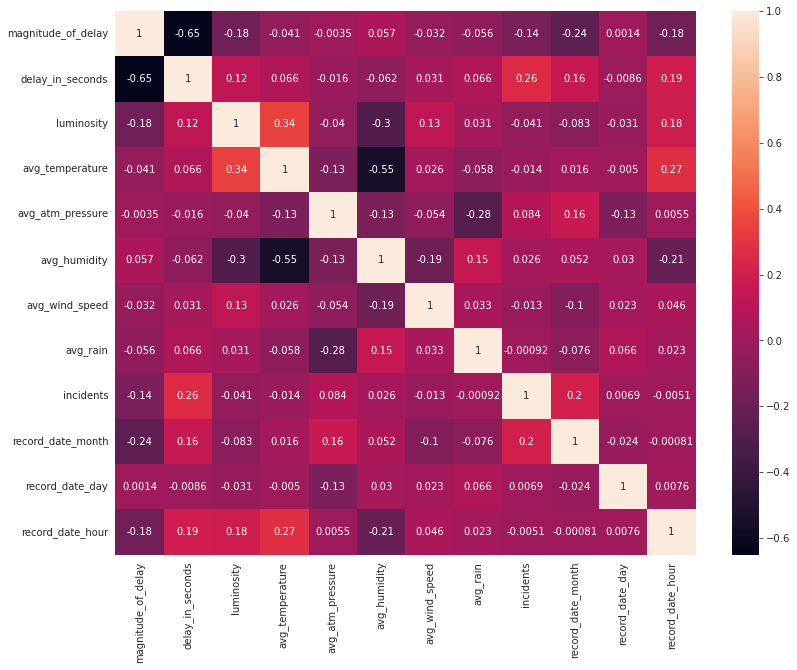

In [13]:
print("** CORR MATRIX **")
plt.figure(figsize = (13,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

### Feature Selection

In [14]:
# Teste: Descarta a coluna avg_rain dado que é a coluna que tem menor correlação com incidents
# df.drop('avg_rain', axis = 1, inplace = True)
# df.drop('avg_wind_speed', axis = 1, inplace = True)
#df.drop('magnitude_of_delay', axis = 1, inplace = True)

### Tratamento da coluna **affected_roads**
Apesar de já termos trabalhado com os restantes dados categóricos, falta-nos tratar ainda os valores da coluna **affected_roads**.\
Para além disto, esta coluna apresenta também missing values.

1. Podemos analisar quantas vezes estradas diferentes foram afetadas, isto é, frequência de estradas mencionadas.
2. Podemos também contar quantas estradas diferentes foram afetadas, ie, número de estradas diferentes mencionadas. (Podemos tentar determinar que quantas mais estradas diferentes forem mencionadas maior será a gravidade do acidente)
3. Podemos também contar quantas estradas foram efetadas, isto é, o número de estradas na string. (Se a colunas affected_roads for povoada cada vez que o acidente for comunicado...)

In [15]:
df.head()

,magnitude_of_delay,delay_in_seconds,affected_roads,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,record_date_month,record_date_day,record_date_hour
0,3,0,",",1,12.0,1013.0,70.0,1.0,1,4,3,15,23
1,3,385,"N101,",1,12.0,1007.0,91.0,1.0,1,4,12,25,18
2,3,69,",",2,14.0,1025.0,64.0,0.0,1,2,3,12,15
3,1,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2,15.0,1028.0,75.0,1.0,1,5,9,29,9
4,3,0,"N101,N101,N101,N101,N101,",2,27.0,1020.0,52.0,1.0,1,1,6,13,11


In [16]:
pd.options.mode.chained_assignment = None  # default='warn'

def drop_affected_roads(df):
    df.drop(['affected_roads'],axis=1, inplace = True)
    
def drop_missing_affected_roads(df):
    df.dropna(inplace=True) # Remover as linhas que tem missing values
    df.reset_index(drop=True, inplace=True)
    
def replace_missing_affected_roads(df):
    df.fillna("",inplace=True) # Remover as linhas que tem missing values
    df.reset_index(drop=True, inplace=True)
        
def count_all_roads_per_line(df):
    # drop_missing_affected_roads(df)
        
    i = 0
    for x in df['affected_roads']:
        y = x.split(",")
        df['affected_roads'][i] = len(y)
        i=i+1
    df['affected_roads'] = df['affected_roads'].astype('int')
    return df
    
    
def count_different_roads_per_line(df):
    # drop_missing_affected_roads(df)
        
    i = 0
    for x in df['affected_roads']:
        y = x.split(",")
        df['affected_roads'][i] = len(list(dict.fromkeys(y)))
        i=i+1
    
    df['affected_roads'] = df['affected_roads'].astype('int')
    return df
    
    
def encode_affected_roads(df):    
    # drop_missing_affected_roads(df)
    
    all_roads = []
    for x in df['affected_roads']:
        y = x.split(",")       
        for k in y:
            all_roads.append(k)       
    all_roads = list(dict.fromkeys(all_roads)) # determina todas as diferentes estradas existentes
    
    i = 0
    for x in df['affected_roads']:
        freq = {}
        y = x.split(",")
        for items in y:
            freq[items] = y.count(items)
        for k in all_roads:
            if(k in freq):
                df.loc[i,k] = freq[k]
            else:
                df.loc[i,k] = 0
        i = i+1
    
    df.drop(['affected_roads'],axis=1, inplace = True)
    return df

replace_missing_affected_roads(df)
#drop_affected_roads(df)
#df = encode_affected_roads(df)
df = count_all_roads_per_line(df)
#df = count_different_roads_per_line(df)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   magnitude_of_delay  5000 non-null   int64  
 1   delay_in_seconds    5000 non-null   int64  
 2   affected_roads      5000 non-null   int64  
 3   luminosity          5000 non-null   int64  
 4   avg_temperature     5000 non-null   float64
 5   avg_atm_pressure    5000 non-null   float64
 6   avg_humidity        5000 non-null   float64
 7   avg_wind_speed      5000 non-null   float64
 8   avg_rain            5000 non-null   int64  
 9   incidents           5000 non-null   int64  
 10  record_date_month   5000 non-null   int64  
 11  record_date_day     5000 non-null   int64  
 12  record_date_hour    5000 non-null   int64  
dtypes: float64(4), int64(9)
memory usage: 507.9 KB


In [18]:
df.head()

,magnitude_of_delay,delay_in_seconds,affected_roads,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,record_date_month,record_date_day,record_date_hour
0,3,0,2,1,12.0,1013.0,70.0,1.0,1,4,3,15,23
1,3,385,2,1,12.0,1007.0,91.0,1.0,1,4,12,25,18
2,3,69,2,2,14.0,1025.0,64.0,0.0,1,2,3,12,15
3,1,2297,11,2,15.0,1028.0,75.0,1.0,1,5,9,29,9
4,3,0,6,2,27.0,1020.0,52.0,1.0,1,1,6,13,11


In [19]:
df.describe()

,magnitude_of_delay,delay_in_seconds,affected_roads,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,record_date_month,record_date_day,record_date_hour
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2.727200,560.567000,5.906400,1.539400,14.583000,1018.145000,74.455000,1.253500,1.10240,3.074000,7.131600,15.888400,11.404800
std,0.685328,1686.859581,3.959542,0.568254,4.820514,5.174372,17.204638,1.269847,0.45821,1.372917,3.442129,8.734736,6.910404
min,1.000000,0.000000,1.000000,1.000000,1.000000,997.000000,6.000000,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000
25%,3.000000,0.000000,5.000000,1.000000,11.000000,1015.000000,63.000000,0.000000,1.00000,2.000000,4.000000,8.000000,5.000000
50%,3.000000,0.000000,5.000000,2.000000,14.000000,1019.000000,78.000000,1.000000,1.00000,4.000000,7.000000,16.000000,11.000000
75%,3.000000,234.000000,6.000000,2.000000,18.000000,1022.000000,90.000000,2.000000,1.00000,4.000000,10.000000,23.000000,17.000000
max,3.000000,31083.000000,46.000000,3.000000,35.000000,1032.000000,100.000000,10.000000,4.00000,5.000000,12.000000,31.000000,23.000000


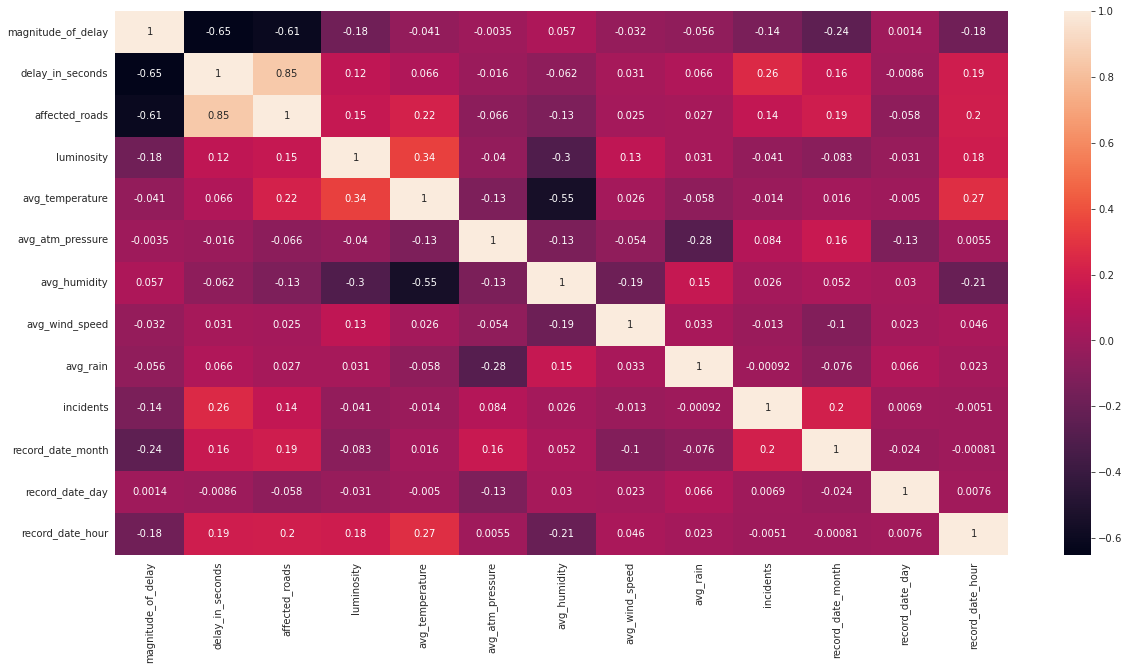

** NULL VALUES?? **


magnitude_of_delay    0
delay_in_seconds      0
affected_roads        0
luminosity            0
avg_temperature       0
avg_atm_pressure      0
avg_humidity          0
avg_wind_speed        0
avg_rain              0
incidents             0
record_date_month     0
record_date_day       0
record_date_hour      0
dtype: int64

In [20]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

print("** NULL VALUES?? **") # check if there are any missing values in this dataframe
df.isnull().sum()

### Tratamento das colunas magnitude_of_delay and delay_in_seconds

### Deteção de outliers

<AxesSubplot:xlabel='Incidents', ylabel='record_date_hour'>

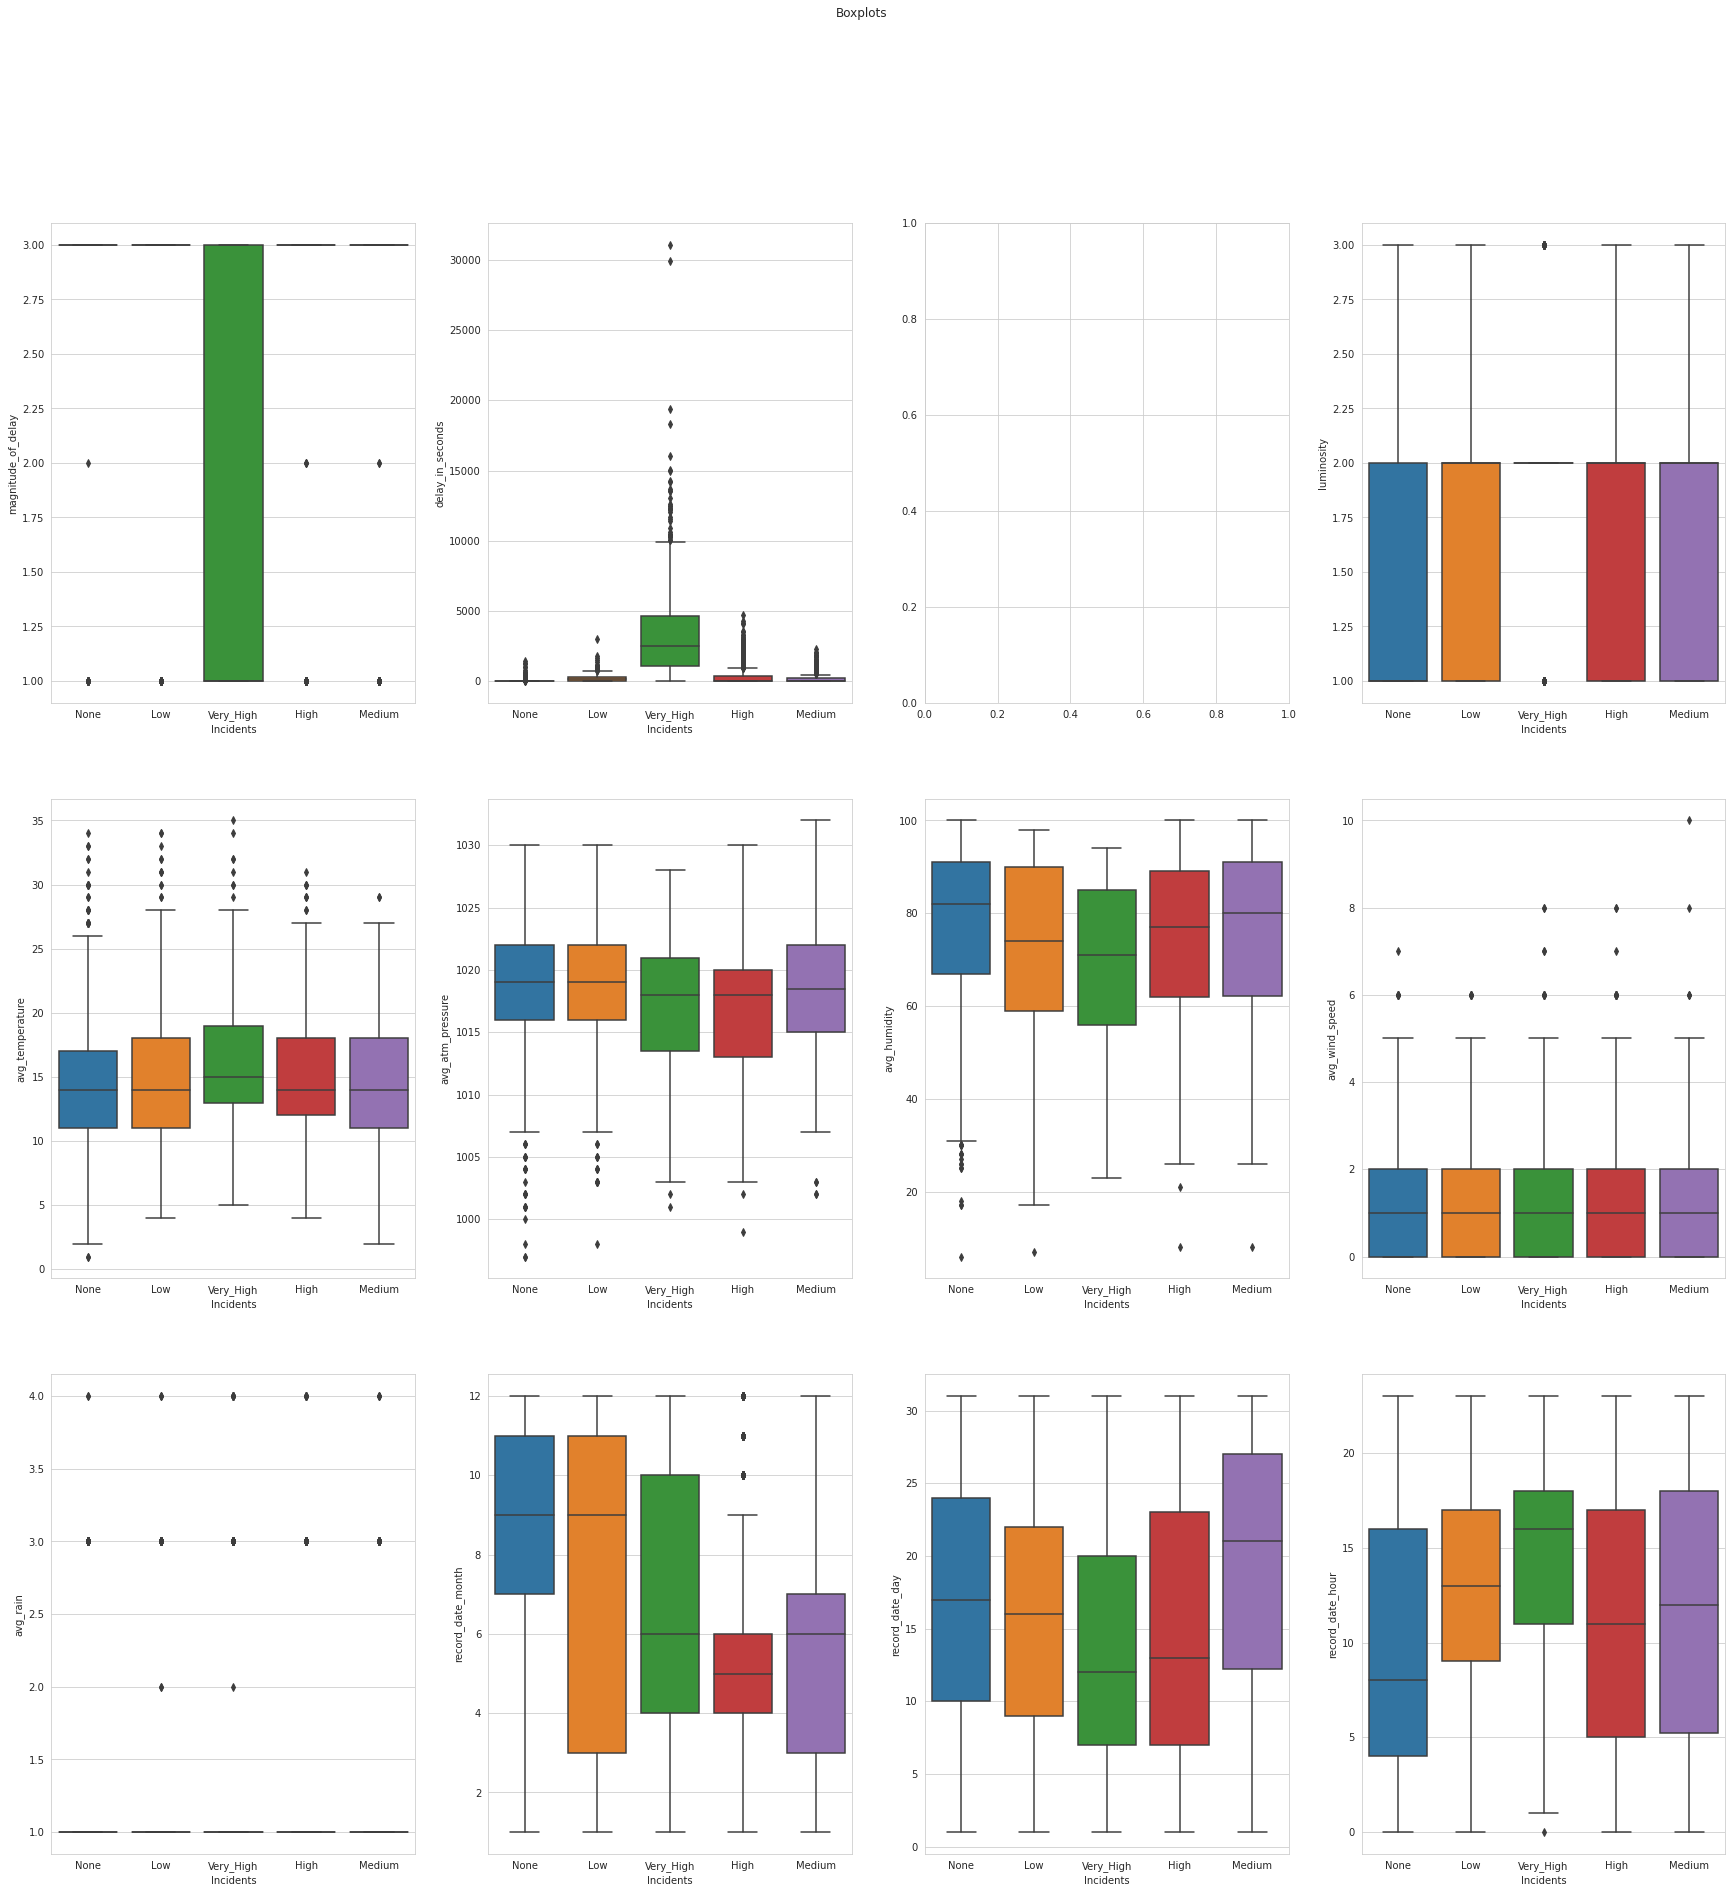

In [21]:
df_copy = df.copy()

df_copy.rename(columns = {'incidents':'Incidents'}, inplace=True)
df_copy.replace(replace_incidents_inverted, inplace=True)

fig, axs = plt.subplots(3,4,figsize=(30,30))
fig.suptitle('Boxplots')

sns.boxplot(x="Incidents", y = "magnitude_of_delay", data=df_copy, ax = axs[0,0])
sns.boxplot(x="Incidents", y = "delay_in_seconds", data=df_copy, ax = axs[0,1])
#sns.boxplot(x="Incidents", y = "affected_roads", data=df_copy, ax = axs[0,2])
sns.boxplot(x="Incidents", y = "luminosity", data=df_copy, ax = axs[0,3])

sns.boxplot(x="Incidents", y = "avg_temperature", data=df_copy, ax = axs[1,0])
sns.boxplot(x="Incidents", y = "avg_atm_pressure", data=df_copy, ax = axs[1,1])
sns.boxplot(x="Incidents", y = "avg_humidity", data=df_copy, ax = axs[1,2])
sns.boxplot(x="Incidents", y = "avg_wind_speed", data=df_copy, ax = axs[1,3])

sns.boxplot(x="Incidents", y = "avg_rain", data=df_copy, ax = axs[2,0])
sns.boxplot(x="Incidents", y = "record_date_month", data=df_copy, ax = axs[2,1])
sns.boxplot(x="Incidents", y = "record_date_day", data=df_copy, ax = axs[2,2])
sns.boxplot(x="Incidents", y = "record_date_hour", data=df_copy, ax = axs[2,3])

<AxesSubplot:xlabel='record_date_hour'>

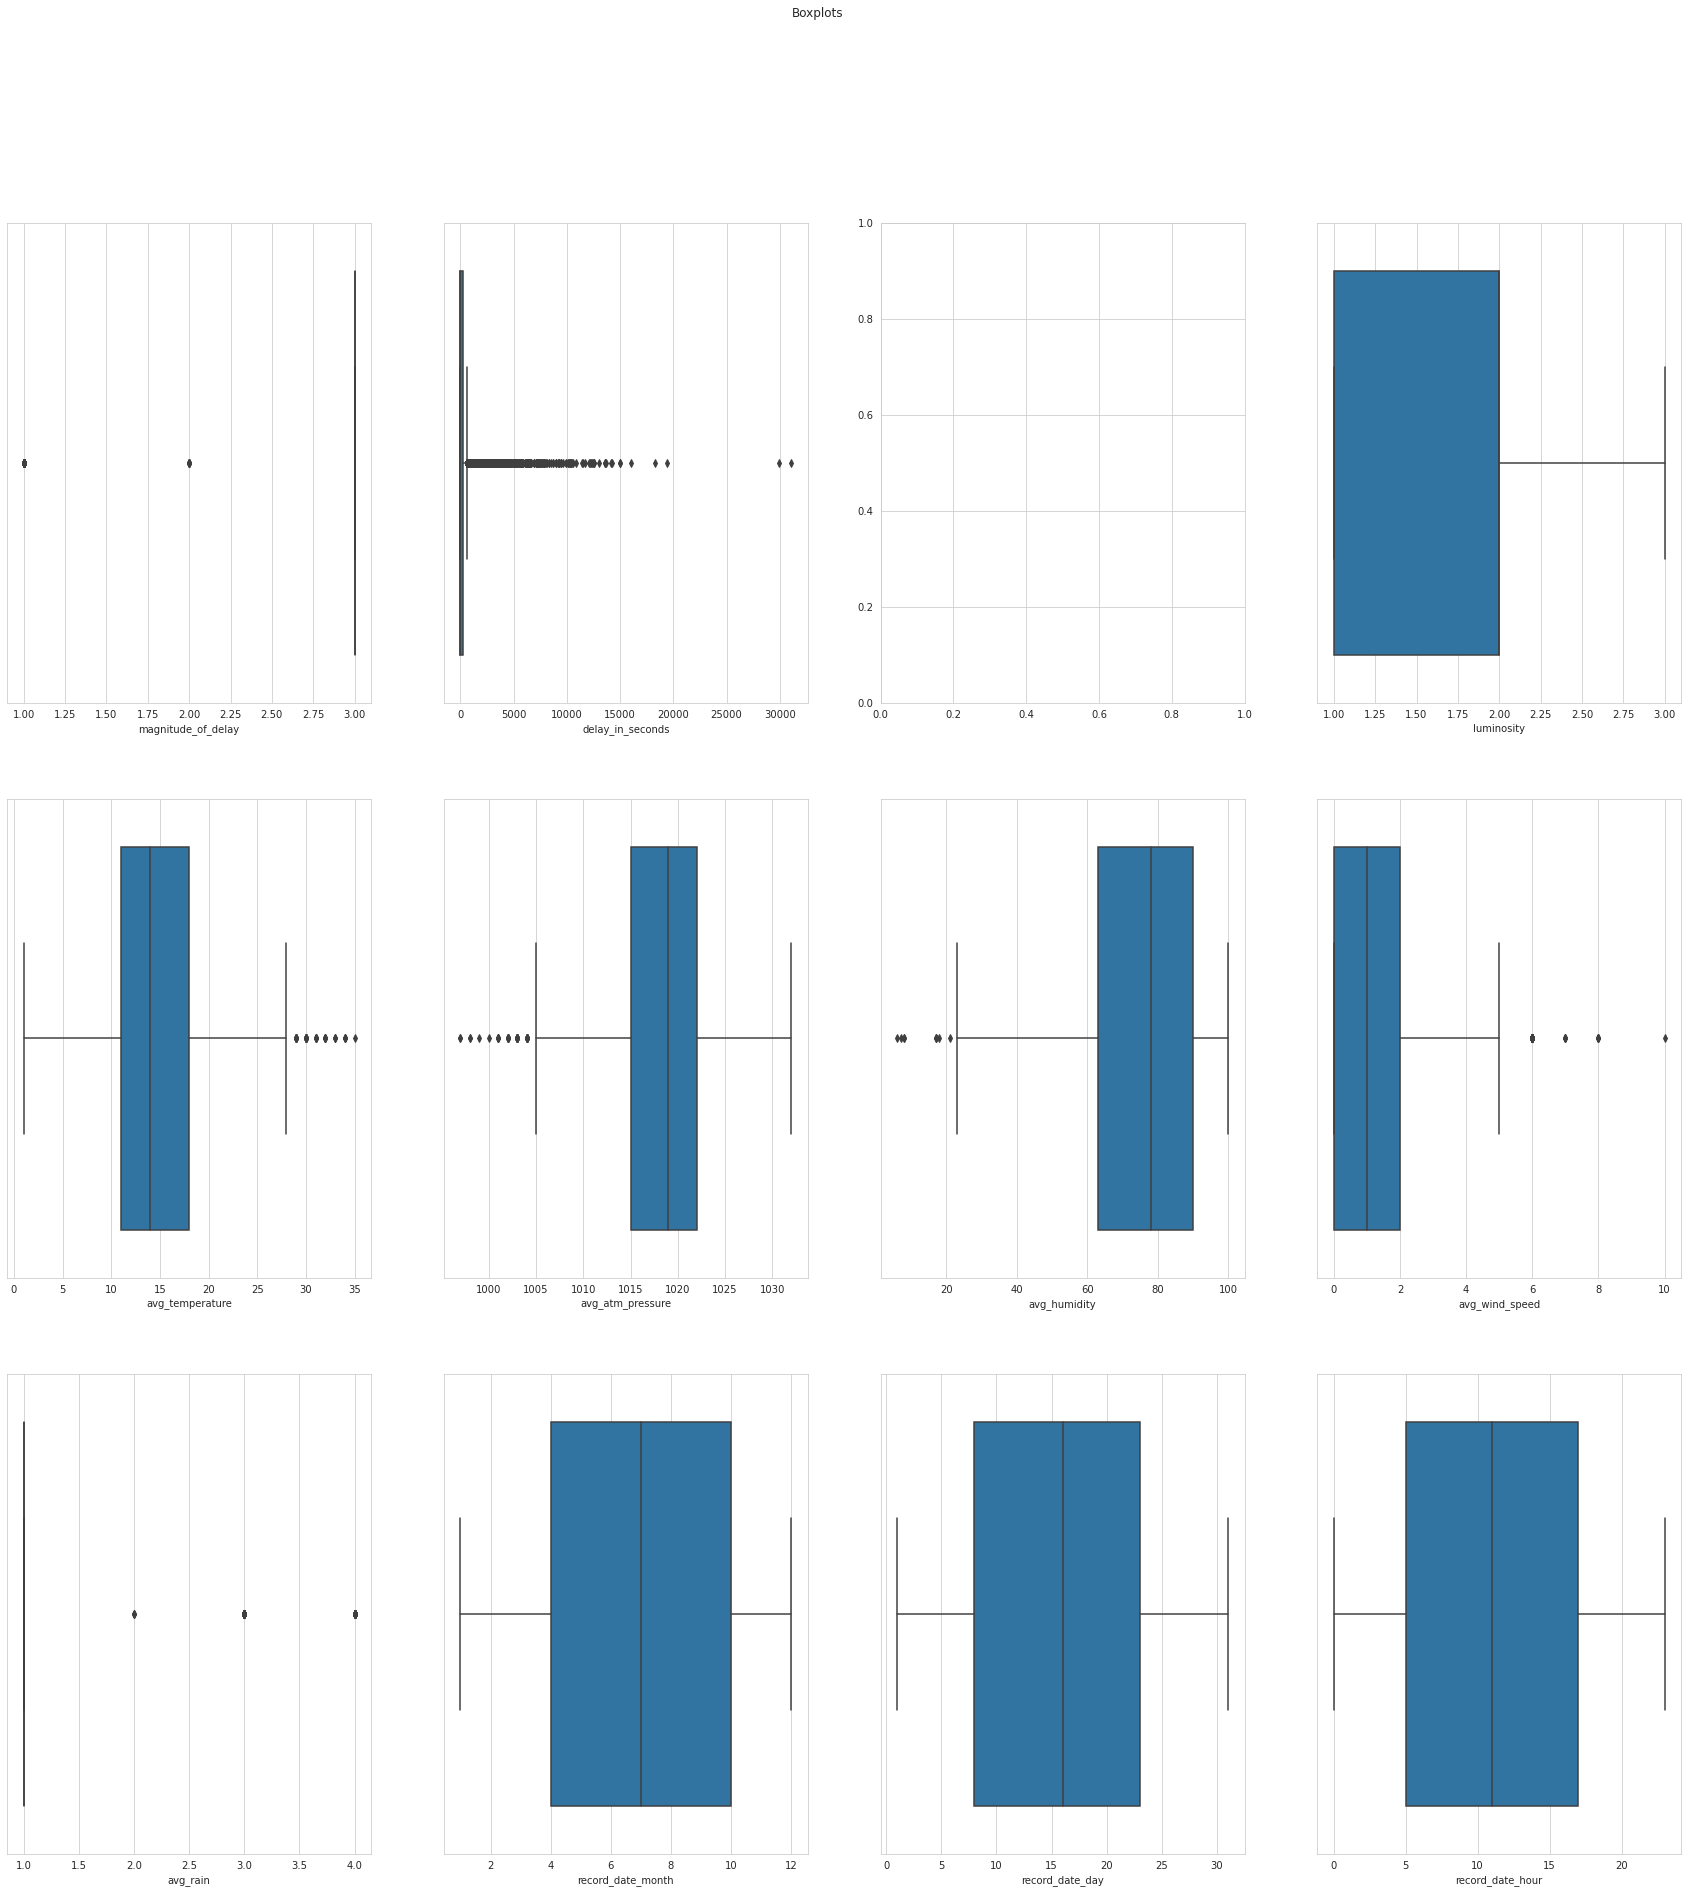

In [22]:
df_copy = df.copy()

df_copy.rename(columns = {'incidents':'Incidents'}, inplace=True)
df_copy.replace(replace_incidents_inverted, inplace=True)

fig, axs = plt.subplots(3,4,figsize=(30,30))
fig.suptitle('Boxplots')

sns.boxplot(x=df["magnitude_of_delay"], data=df_copy, ax = axs[0,0])
sns.boxplot(x=df["delay_in_seconds"], data=df_copy, ax = axs[0,1])
#sns.boxplot(x=df["affected_roads"], data=df_copy, ax = axs[0,2])
sns.boxplot(x=df["luminosity"], data=df_copy, ax = axs[0,3])

sns.boxplot(x=df["avg_temperature"], data=df_copy, ax = axs[1,0])
sns.boxplot(x=df["avg_atm_pressure"], data=df_copy, ax = axs[1,1])
sns.boxplot(x=df["avg_humidity"], data=df_copy, ax = axs[1,2])
sns.boxplot(x=df["avg_wind_speed"], data=df_copy, ax = axs[1,3])

sns.boxplot(x=df["avg_rain"], data=df_copy, ax = axs[2,0])
sns.boxplot(x=df["record_date_month"], data=df_copy, ax = axs[2,1])
sns.boxplot(x=df["record_date_day"], data=df_copy, ax = axs[2,2])
sns.boxplot(x=df["record_date_hour"], data=df_copy, ax = axs[2,3])

In [23]:
# Replace outliers:
def replaceOutliers(df):
    for x in ['magnitude_of_delay','delay_in_seconds', 'affected_roads', 'avg_temperature',
              'avg_atm_pressure','avg_humidity', 'avg_wind_speed', 'avg_rain']:
        Q1 = df[x].quantile(0.25)
        Q3 = df[x].quantile(0.75)
        IQR = Q3 - Q1
        whisker_width = 1.5
        lower_whisker = Q1 - (whisker_width*IQR)
        upper_whisker = Q3 + (whisker_width*IQR)
        df[x] = np.where(df[x]>upper_whisker,upper_whisker,np.where(df[x]<lower_whisker,lower_whisker,df[x]))
    #return df

#replaceOutliers(df)
#df.info()
#df.describe()

### Balanceamento de *incidents*

Como vimos anteriormente, cada classe não tem o mesmo número de instâncias, portanto, podemos tentar fazer com que todas classes tenham o mesmo número de instâncias.

Balancing data using SMOTE technique

In [27]:
from imblearn.over_sampling import SMOTE

def apply_smote(df):
    dfTrain, dfTest = train_test_split(df, test_size = 0.3, random_state=2022)

    #for i in range(5):
    #    print("Before OverSampling, counts of label" + "i" + ": {}".format(sum(ytrain['incidents'] == i)))
    #    print("Before OverSampling, counts of label" + "i" + ": {}".format(sum(Xtrain['incidents'] == i)))
    
    print(dfTrain.incidents.value_counts())

    Xtrain = dfTrain.drop(['incidents'], axis = 1)
    ytrain = dfTrain['incidents']
    X_test = dfTest.drop(['incidents'], axis = 1)
    y_test = dfTest['incidents']
    

    
    #print(Xtrain.incidents.value_counts())
    
    smote = SMOTE(random_state = 2001, sampling_strategy='not majority')
    X_train_sm, y_train_sm = smote.fit_resample(Xtrain, ytrain)

    #print(X_train_sm.incidents.value_counts())
    for i in range(5):
        print("After OverSampling, counts of label"+str(i)+": {}".format(sum(y_train_sm == i+1)))
    
    #for i in range(5):
    #    print("After OverSampling, counts of label "+"i"+": {}".format(sum(y_train_sm['incidents'] == i)))
   #    print("After OverSampling, counts of label "+"i"+": {}".format(sum(X_train_sm['incidents'] == i)))

    return X_train_sm, y_train_sm, X_test, y_test

In [24]:
def showHistogramIncidents(df):
    sns.set_style("whitegrid")
    sns.countplot(x="incidents", data=df, palette="RdBu_r")
    plt.show()


def balancedData(df):
    #print(df.incidents.value_counts())
    
    count_4, count_1, count_2, count_5, count_3 = df.incidents.value_counts()
    #print(count_1)
    #print(count_2)
    #print(count_3)
    #print(count_4)
    #print(count_5)
        
    df_class_4 = df[df['incidents'] == 4]
    
    df_class_2 = df[df['incidents'] == 2]
    df_class_2_over = df_class_2.sample(count_4, replace=True)
    
    df_class_3 = df[df['incidents'] == 3]
    df_class_3_over = df_class_3.sample(count_4, replace=True)
    
    df_class_1 = df[df['incidents'] == 1]
    df_class_1_over = df_class_1.sample(count_4, replace=True)
    
    df_class_5 = df[df['incidents'] == 5]
    df_class_5_over = df_class_5.sample(count_4, replace=True)
        
    df_test_over = pd.concat([df_class_4, df_class_2_over,
                              df_class_3_over, df_class_1_over,
                              df_class_5_over], axis=0)
    
    #print(df_test_over.incidents.value_counts())
    showHistogramIncidents(df_test_over)
    return df_test_over
    
#df = balancedData(df)

## Deep Learning

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.preprocessing import MinMaxScaler
# 
# pd.options.mode.chained_assignment = None  # default='warn'
# 
# def minMaxScaler(df):
#     df_scaled = df.copy()
#     scaler = MinMaxScaler()
#     df_scaled_cols = df.columns
#     df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled_cols)
#     return df_scaled, scaler
# 
# ## Deep Learning:
# def DLModel(activation='relu', learning_rate=0.001):
# 
#     # There are differente layers stacked
#     model = Sequential()
#     # Input Layer
#     model.add(Dense(11,input_dim=11, activation=activation)) # 16 neurons ; 11 input features
#     model.add(Dense(8, activation=activation)) # 8 neurons
#     #model.add(Dense(11, activation=activation)) # 8 neurons
#     # Output Layer
#     model.add(Dense(5, activation=activation)) # Number of classes to predict 5
#     
#     loss_fn = tf.keras.losses.Poisson()
#     # loss_fn2 = tf.keras.losses.CategoricalCrossentropy()
#         
#     #Compile the model
#     #Define the loss function, the otimizer and metrics to be used
#     model.compile(
#         loss = loss_fn,
#         optimizer = tf.optimizers.Adam(learning_rate),
#         metrics = ['accuracy']) #tf.keras.metrics.Precision(),tf.keras.metrics.Recall()
#     return model
# 
# 
# model = DLModel()
# model.summary()
# model.save('/home/mariana/Universidade/4º Ano/DAA/TrabalhoPrático')
# 
# X = df.drop(['incidents'], axis = 1)
# y = df['incidents']
# 
# X, scaler_X = minMaxScaler(X)
# y, scaler_y = minMaxScaler(y)
# 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2022)
# 
# model = KerasClassifier(build_fn = DLModel, 
#                         epochs=20, # number of passes of the entire training dataset
#                         batch_size=32, # number of training samples in one forward/backward pass
#                         verbose = 2)
# 
# model.fit(X_train,y_train)
# y_pred = model.predict(X_test)
# 
# 
# frame = { 'incidents': y_pred }
# y_pred = scaler_y.inverse_transform(y_pred)
# frame = { 'incidents': y_test }
# y_test = scaler_y.inverse_transform(y_test)
# 
# print(np.unique(y_pred))
# print(classification_report(y_test,y_pred))
# 
# Grid Search
#TUNING_DICT = {
#    'activation' : ['relu', 'sigmoid'],
#    'learning_rate' : [0.01, 0.001, 0.0001]
#}
#
#kf = KFold(n_splits=5, shuffle=True, random_state=2022)
#grid_search = GridSearchCV(estimator=model,
#                           param_grid=TUNING_DICT,
#                           cv=kf,
#                           scoring = 'accuracy',
#                           refit = 'True',
#                           verbose = 1)
#
#grid_search.fit(X_train, y_train, validation_split=0.2) # 20% validation that, used to evaluate model
#
#print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
#
#y_pred = grid_search.predict(X_test)
#
#cm = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot()
#plt.show()
#print(classification_report(y_test,y_pred))

## Models

In [26]:
def Split_Training_Test_Set(df):
    X = df.drop(['incidents'], axis = 1)
    y = df['incidents']
    
    #scaler_X = MinMaxScaler(feature_range=(0,1)).fit(X)
    #scaler_y = MinMaxScaler(feature_range=(0,1)).fit(y)
    #X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)
    #y_scaled = pd.DataFrame(scaler_y.transform(y[y.columns]), columns=y.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2022)
    showHistogramIncidents(df_test_over)
    plt.clf()
    showHistogramIncidents(df_test_over)
    
    return X_train, X_test, y_train, y_test

In [25]:
def getModel(modelType):
    if (modelType == "DecisionTree"):
        model = DecisionTreeClassifier() # criterion = 'entropy', splitter = 'best', max_depth = 10
    elif(modelType == "RandomForest"):
        model = RandomForestClassifier(criterion='entropy', n_estimators=150, max_features='log2', random_state=2001) 
    elif(modelType == "AdaBoost"):
        model = AdaBoostClassifier(algorithm='SAMME.R', n_estimators=85, learning_rate=1.5, random_state=2001)
    elif(modelType == "CatBoost"):
        model = CatBoostClassifier()
    elif(modelType == "GBoost"):
        model = GradientBoostingClassifier(criterion= 'friedman_mse', learning_rate= 0.2, loss= 'log_loss', n_estimators= 110)
    elif(modelType == "BalRandomForest"):
        model = BalancedRandomForestClassifier(criterion= 'entropy', max_features= 'sqrt', n_estimators= 150, random_state= 2001)
    elif(modelType == "Bagging"):
        model = BaggingClassifier(n_estimators=150)
    else:
        model = DecisionTreeClassifier()
    return model

In [28]:
def test_model(df,grid_search):
    if(not(grid_search)):
        # Choose Model:
        model = getModel("Bagging")
        
        X_train, X_test, y_train, y_test = Split_Training_Test_Set(df)
        model = model.fit(X_train, y_train)
        
        #X_train_smote, y_train_smote, X_test, y_test = apply_smote(df)
        #model = model.fit(X_train_smote, y_train_smote)
        
        y_pred = model.predict(X_test)
        evaluation_model(y_test, y_pred)

    if(grid_search):
        X = df.drop(['incidents'], axis = 1)
        y = df['incidents']
        
        #Decision Tree:
        #log_loss deu asneira
        #params = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [5,10,15]}    
        #grid = gridSearch(model, params)
        #grid = grid.fit(X, y)
        #print(grid.best_params_)

        #Random Forest Classifier:
        # log_loss deu asneira
        #model = getModel("BalRandomForest")
        #params = {'criterion': ['entropy', 'gini'], 'n_estimators': [75,100,150,200], 'max_features': ['sqrt','log2'], 'random_state':[2001]} # , 'gini' , ,'log2'  
        
        #model = getModel("AdaBoost")
        #params = {'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [1.3,1.5,1.7], 'n_estimators': [60,75,85]}
        
        #model = getModel("CatBoost")
        #params = {'depth'         : [5,15],
        #         'learning_rate'  : [0.01,1],
        #          'iterations'    : [750,1500],
        #         }
        
        model = getModel("Bagging")
        params = {'n_estimators':[125,150,175,200]}
        
        #model = getModel("GBoost")
        #params = {'criterion': ['friedman_mse', 'squared_error'], 'learning_rate': [0.13,0.15,0.2], 'n_estimators': [110,125,150], 'loss': ['log_loss']}   
        
        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        grid = GridSearchCV(model, params, scoring='accuracy', n_jobs=-1, cv=cv)
        grid = grid.fit(X,y)
        print(grid.best_params_)
        print(grid.best_score_)

## Evaluation

In [ ]:
# Classification_report
def evaluation_model(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    print(classification_report(y_test,y_pred))

## Build File with Predictions

### Apply Preprocessing of training dataset

In [29]:
def preprocessing(df):
    # Replace missing data
    df['affected_roads'].fillna("", inplace=True)
    print(len(df['delay_in_seconds']))
    encoding_categorical_data(df)
    print(len(df['delay_in_seconds']))
    drop_columns_zero_std(df)
    print(len(df['delay_in_seconds']))
    df = count_all_roads_per_line(df)
    print(len(df['delay_in_seconds']))
    #df.drop('magnitude_of_delay', axis=1, inplace=True)
    print(len(df['delay_in_seconds']))
    #replaceOutliers(df)
    #print(len(df['delay_in_seconds']))
    return df
    

In [30]:
def predict_doc(df):
    X = df.drop(['incidents'], axis = 1)
    y = df['incidents']
    
    model = getModel("RandomForest")
    model = model.fit(X, y)

    df_test = pd.read_csv("sbstpdaa2223/test_data.csv")
    df_test = preprocessing(df_test)

    y_pred = model.predict(df_test)

    # RowId,Incidents
    pred = pd.DataFrame()
    pred['RowId'] = range(1, len(y_pred)+1)
    pred['Incidents'] = y_pred
    pred.replace(replace_incidents_inverted, inplace=True)
    pred.to_csv('Tries/Group16_Try11.csv', index = False)  

## Main

In [31]:
if __name__ == "__main__":
    grid_search = False
    test_model(df, grid_search)
    
    #predict_doc(df)
    
    # {'incidents': {'High': 1, 'Low': 2, 'Medium': 3, 'None': 4, 'Very_High': 5}}

{'n_estimators': 150}
